In [8]:
# Import the required libraries
import os
import torch
import numpy as np
import transformers
from transformers import AutoModelForSequenceClassification, GlueDataTrainingArguments, AutoTokenizer
import torchmetrics
import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from apx import ApproxEmbed, ApxSVD, train_apx
from glue_score import GLUE_TASKS, make_model, Glue, get_dataloaders, validate, get_metrics

In [9]:
transformers.utils.logging.set_verbosity_error()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

epochs=5
batch_size=32

lr=5e-5
levels=8
channels=8
bits=8
neurons=64
nn_levels=2
apx_epochs=5000
apx_batch_size=2**14
checkpoint_every=100

save_path = 'results/compression_finetuned/'

norms = [1,1.25,1.5,1.75,2]

In [10]:
task=list(GLUE_TASKS.keys())[2]
args=GLUE_TASKS[task]
task

'mrpc'

In [11]:
model=make_model('prajjwal1/bert-tiny',args)
    
train_dataloader, val_dataloader = get_dataloaders(args, task, batch_size)
metrics = get_metrics(args)

Glue(model, tokenizer, task, args, epochs=epochs, steps_validate=0.2, train_dataloader=train_dataloader, val_dataloader=val_dataloader);

embeddings = model.bert.embeddings.word_embeddings.weight.to(device)

results={}

val_metrics = validate(model, tokenizer, val_dataloader, metrics, args)
results['Original']=[m.item() for m in val_metrics]
print('Original', val_metrics)

Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (C:/Users/Sam/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Epoch: 5: 100%|██████████| 115/115 [00:03<00:00, 38.05it/s, loss: 0.15] 


Original [tensor(0.4950), tensor(0.5378)]


In [12]:
norm=2

In [14]:
apx_model = make_model('prajjwal1/bert-tiny',args)
apx_model.load_state_dict(model.state_dict())

apx = ApproxEmbed(levels = levels, 
        feature_dim = channels,
        num_words = embeddings.shape[0],
        output_dims = embeddings.shape[1],
        feature_std = 0.1,
        feature_bias = 0.0,
        codebook_bitwidth=bits,
        neurons = neurons,
        nn_levels=nn_levels).to('cuda')

run = train_apx(apx, embeddings, apx_epochs, apx_batch_size, checkpoint_every, save_path, verbose=True);
apx.fix_indices()
apx_model.bert.embeddings.word_embeddings = apx

val_metrics = validate(apx_model, tokenizer, val_dataloader, metrics, args)
results["Norm "+str(norm)]=[m.item() for m in val_metrics]
print(norm, val_metrics)

4999 0.0031031                                                                        0.10002279281616211
2 [tensor(0.4061), tensor(0.5000)]


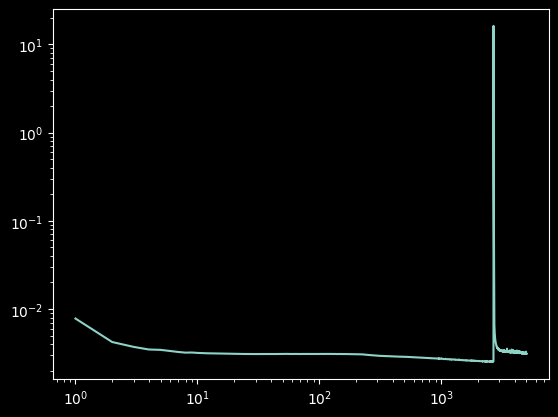

In [16]:
plt.plot(np.arange(len(run['loss']))+1,run['loss'])
plt.yscale('log')
plt.xscale('log')

In [19]:
order=np.arange(embeddings.shape[0])
tot_loss=0
tot_n=0
np.random.shuffle(order)
for batch in range(int(np.ceil(len(order)/batch_size))):

    positions = torch.tensor(order[batch*batch_size:(batch+1)*batch_size],dtype=int,device=device)
    embed_preds = apx(positions)

    embeds = embeddings[positions]
    loss=torch.mean(torch.pow(torch.abs(embed_preds-embeds), norm))

    tot_loss+=loss.item()*len(order[batch*batch_size:(batch+1)*batch_size])
    tot_n+=len(order[batch*batch_size:(batch+1)*batch_size])
print(tot_loss/tot_n)

0.0025183973592193343


In [20]:
S,V,D = np.linalg.svd(embeddings.detach().cpu(),full_matrices=False)

# plot 
N=list(np.arange(40)+1)

loss=np.array([torch.mean(torch.square(torch.tensor((S[:,:n]*V[:n])@D[:n],device=embeddings.device)-embeddings)).item() for n in N])
loss[5]

0.002267783274874091

In [ ]:


# clone the model to not modify the original
apx_model = make_model('prajjwal1/bert-tiny',args)
apx_model.load_state_dict(model.state_dict())

apxSVD = ApxSVD(apx_model.bert.embeddings.word_embeddings.weight, 5)
apx_model.bert.embeddings.word_embeddings = apxSVD.to('cuda')

val_metrics = validate(apx_model, tokenizer, val_dataloader, metrics, args)
results['SVD']=[m.item() for m in val_metrics]
print('SVD', val_metrics)

In [4]:
RESULTS={}
for task in list(GLUE_TASKS.keys()):
    
    print(task)
    args=GLUE_TASKS[task]
    model=make_model('prajjwal1/bert-tiny',args)
    
    train_dataloader, val_dataloader = get_dataloaders(args, task, batch_size)
    metrics = get_metrics(args)

    Glue(model, tokenizer, task, args, epochs=epochs, steps_validate=0.2, train_dataloader=train_dataloader, val_dataloader=val_dataloader);

    embeddings = model.bert.embeddings.word_embeddings.weight.to(device)

    results={}

    val_metrics = validate(model, tokenizer, val_dataloader, metrics, args)
    results['Original']=[m.item() for m in val_metrics]
    print('Original', val_metrics)

    for norm in norms:

        # clone the model to not modify the original
        apx_model = make_model('prajjwal1/bert-tiny',args)
        apx_model.load_state_dict(model.state_dict())

        apx = ApproxEmbed(levels = levels, 
                feature_dim = channels,
                num_words = embeddings.shape[0],
                output_dims = embeddings.shape[1],
                feature_std = 0.1,
                feature_bias = 0.0,
                codebook_bitwidth=bits,
                neurons = neurons,
                nn_levels=nn_levels).to('cuda')

        train_apx(apx, embeddings, apx_epochs, apx_batch_size, checkpoint_every, save_path);
        apx.fix_indices()
        apx_model.bert.embeddings.word_embeddings = apx

        val_metrics = validate(apx_model, tokenizer, val_dataloader, metrics, args)
        results["Norm "+str(norm)]=[m.item() for m in val_metrics]
        print(norm, val_metrics)

    # clone the model to not modify the original
    apx_model = make_model('prajjwal1/bert-tiny',args)
    apx_model.load_state_dict(model.state_dict())

    apxSVD = ApxSVD(apx_model.bert.embeddings.word_embeddings.weight, 5)
    apx_model.bert.embeddings.word_embeddings = apxSVD.to('cuda')

    val_metrics = validate(apx_model, tokenizer, val_dataloader, metrics, args)
    results['SVD']=[m.item() for m in val_metrics]
    print('SVD', val_metrics)

    RESULTS[task]=results

cola


KeyboardInterrupt: 

In [ ]:
RESULTS

{'cola': {'Original': [0], 'Norm1.25': [0], 'SVD': [0]}}

In [ ]:
save_path='results/'
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

torch.save(RESULTS, save_path+'glue_results_no_retrain.pth')

In [ ]:
import torch
import pandas as pd

run_dict=torch.load('results/glue_results_no_retrain.pth')

for k_runs, runs in run_dict.items():
    for k_run, run in runs.items():
        run_dict[k_runs][k_run]=f"{run[0]*100:,.1f}" if len(run)==1 else f"{run[0]*100:,.1f}/{run[1]*100:,.1f}"
df=pd.DataFrame(run_dict)
df

,cola
Norm1.25,0.0
Original,0.0
SVD,0.0
